In [2]:
from community_knapsack import *
from evaluation.evalutils import *
import matplotlib.pyplot as plt

In [3]:
# Algorithms
# Brute force excluded because it cannot solve n>=50.
exact_algorithms = [
    PBSingleAlgorithm.MEMOIZATION,
    PBSingleAlgorithm.DYNAMIC_PROGRAMMING,
    PBSingleAlgorithm.BRANCH_AND_BOUND,
    PBSingleAlgorithm.ILP_SOLVER
]
exact_labels = ['MEM', 'DYP', 'BRB', 'IPS']

approximation_algorithms = [
    PBSingleAlgorithm.GREEDY,
    PBSingleAlgorithm.RATIO_GREEDY,
    PBSingleAlgorithm.FPTAS,
    PBSingleAlgorithm.SIMULATED_ANNEALING,
    PBSingleAlgorithm.GENETIC_ALGORITHM
]
approximation_labels = ['GRE', 'RAG', 'FPA', 'SIA', 'GEN']

# PyPlot Configuration
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
alpha_cycle = [1, 1, 1, 1, 1]
marker_size_cycle = [4, 4, 4, 4, 4]

In [4]:
# This notebook explores the runtime and value of algorithms as the budget increases:

In [5]:
# Generate Problems
generator = PBGenerator(seed=181)

num_projects = 50
num_voters = 3000

min_budget = 100_000
max_budget = 1_000_000
step_budget = 20_000

cost_bound = (5_000, 50_000)

problems = []
for budget in range(min_budget, max_budget + 1, step_budget):
    problems.append(generator.generate_single_problem(
        num_projects_bound=(num_projects, num_projects),
        num_voters_bound=(num_voters, num_voters),
        budget_bound=(budget, budget),
        cost_bound=cost_bound
    ))

In [6]:
def plot_all_y(x_axis, y_axes, marker='o-', x_label='', y_label='', labels=None, marker_sizes=None, colors=None, alphas=None, fix_y=None):
    valid = lambda feature, index: feature and index < len(feature) and feature[index] != -1
    for idx, y_axis in enumerate(y_axes):
        plot = plt.plot(x_axis, y_axis, marker)
        if valid(labels, idx):
            plot[0].set_label(labels[idx])
        if valid(marker_sizes, idx):
            plot[0].set_markersize(marker_sizes[idx])
        if valid(colors, idx):
            plot[0].set_color(colors[idx])
        if valid(alphas, idx):
            plot[0].set_alpha(alphas[idx])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.minorticks_on()
    ax = plt.gca()
    ax.ticklabel_format(axis='x', style='sci', scilimits=(3, 3))
    ax.xaxis.offsetText.set_visible(False)
    ax.set_xticks([tick for tick in range(min_budget, max_budget + 1, step_budget)], minor=True)
    plt.grid(which='both', alpha=0.2)
    if fix_y: ax.set_ylim(fix_y)
    legend = plt.legend()
    for idx in range(len(labels if labels else [])):
        legend.legend_handles[idx].set_markersize(4)
        legend.legend_handles[idx].set_alpha(1.0)

In [7]:
exact_results = solve_problems(problems, exact_algorithms, timeout=120, max_fail=-1, file_name='ext-increasing-budget.txt', output=True)

In [8]:
approximation_results = solve_problems(problems, approximation_algorithms, timeout=120, max_fail=-1, file_name='apx-increasing-budget.txt', output=True)

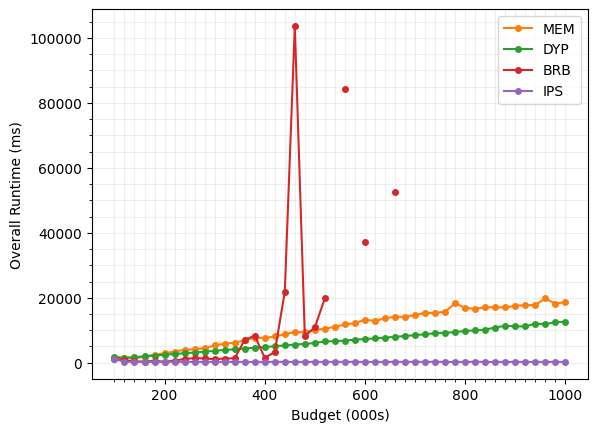

In [9]:
# EXACT ALGORITHMS RUNTIME OVER THE PROBLEMS
# Brute force excluded because it cannot solve n>=50.
plot_all_y(
    x_axis=list(range(min_budget, max_budget + 1, step_budget)),
    y_axes=[get_y(exact_results, len(problems), algorithm, 2) for algorithm in exact_algorithms],
    labels=exact_labels,
    marker_sizes=marker_size_cycle,
    x_label='Budget (000s)',
    y_label='Overall Runtime (ms)',
    colors=color_cycle[1:]
)

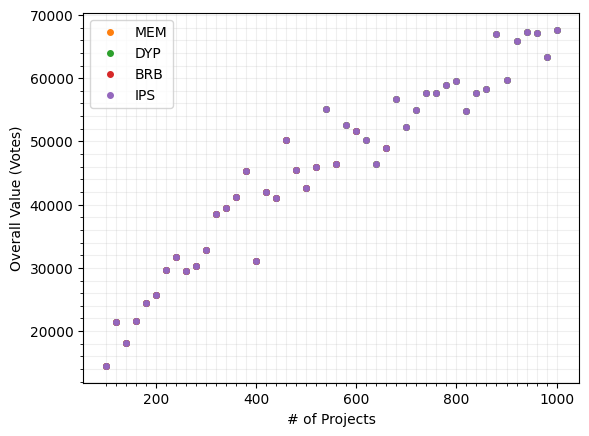

In [37]:
# EXACT ALGORITHMS VALUE OVER THE PROBLEMS
# This just verifies that all the algorithms find the same optimum value.
plot_all_y(
    x_axis=list(range(min_budget, max_budget + 1, step_budget)),
    y_axes=[get_y(exact_results, len(problems), algorithm, 0) for algorithm in exact_algorithms],
    labels=exact_labels,
    marker='o',
    marker_sizes=marker_size_cycle,
    x_label='# of Projects',
    y_label='Overall Value (Votes)',
    colors=color_cycle[1:]
    # fix_y=[-500, 12000]
)

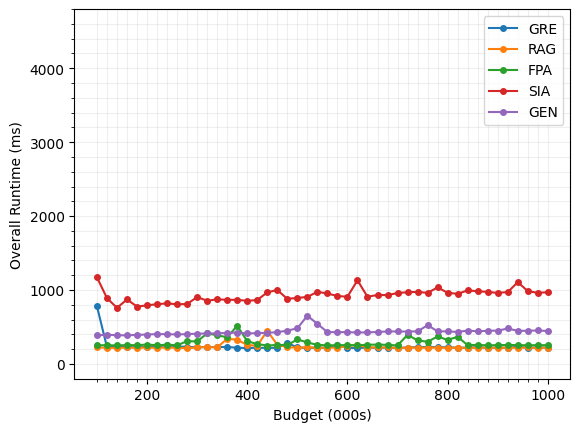

In [38]:
# APPROXIMATION ALGORITHMS RUNTIME OVER THE PROBLEMS
plot_all_y(
    x_axis=list(range(min_budget, max_budget + 1, step_budget)),
    y_axes=[get_y(approximation_results, len(problems), algorithm, 2) for algorithm in approximation_algorithms],
    labels=approximation_labels,
    marker_sizes=marker_size_cycle,
    x_label='Budget (000s)',
    y_label='Overall Runtime (ms)',
    fix_y=[-200, 4800]  # not sure to include
)

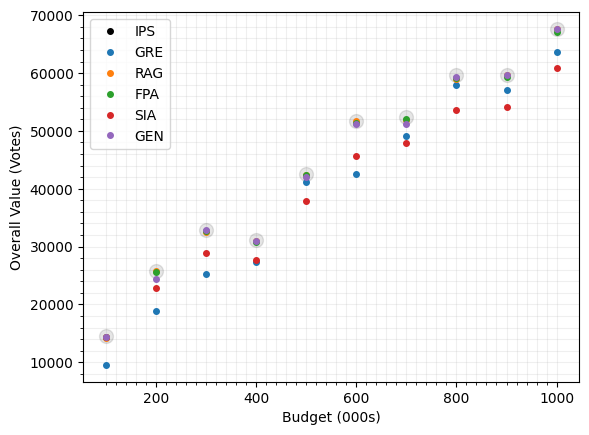

In [39]:
# APPROXIMATION ALGORITHM VALUE EFFICACY VS ILP SOLVER
drip_x = [x for idx, x in enumerate(range(min_budget, max_budget + 1, step_budget)) if idx % 5 == 0]
drip_y = [get_y(exact_results, len(problems), PBSingleAlgorithm.ILP_SOLVER, 0)] + \
        [get_y(approximation_results, len(problems), algorithm, 0) for algorithm in approximation_algorithms]
drip_y = [[yv for idx, yv in enumerate(y) if idx % 5 == 0] for y in drip_y]
plot_all_y(
    x_axis=drip_x,
    y_axes=drip_y,
    labels=['IPS'] + approximation_labels,
    x_label='Budget (000s)',
    y_label='Overall Value (Votes)',
    marker='o',
    marker_sizes=[10] + marker_size_cycle,
    colors=['black'] + color_cycle,
    alphas=[0.1] + alpha_cycle,
)

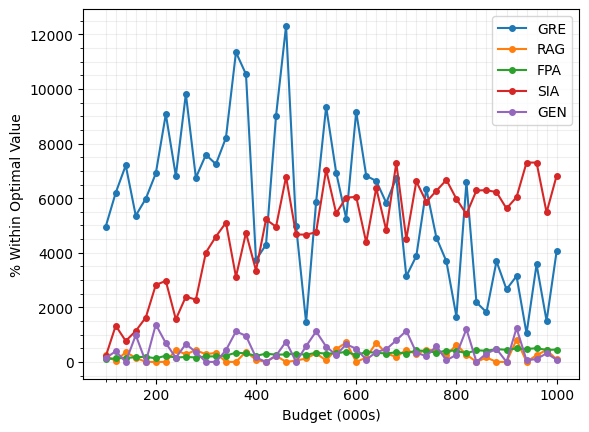

In [40]:
# APPROXIMATION ALGORITHM VALUE % VS ILP SOLVER
opt_y = [get_y(exact_results, len(problems), PBSingleAlgorithm.ILP_SOLVER, 0)]
perc_y = [get_y(approximation_results, len(problems), algorithm, 0) for algorithm in approximation_algorithms]
perc_y = [[(opt_y[0][i] - ay) for i, ay in enumerate(y)] for y in perc_y]

plot_all_y(
    x_axis=list(range(min_budget, max_budget + 1, step_budget)),
    y_axes=perc_y,
    labels=approximation_labels,
    x_label='Budget (000s)',
    y_label='% Within Optimal Value',
    marker_sizes=marker_size_cycle
)

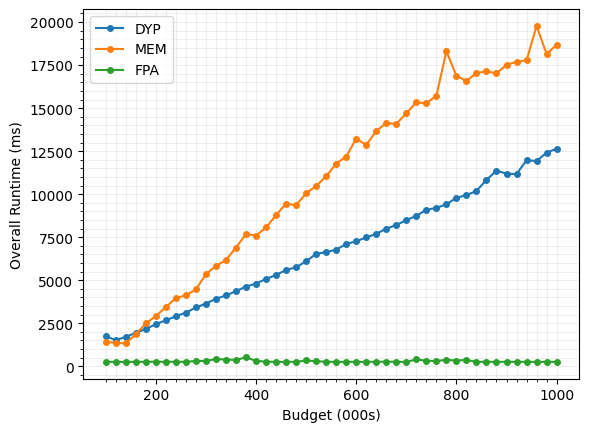

In [41]:
# COMPARE DYNAMIC PROGRAMMING, MEMOIZATION AND FPTAS RUNTIME
rt_dyn_y = [
    get_y(exact_results, len(problems), PBSingleAlgorithm.DYNAMIC_PROGRAMMING, 2),
    get_y(exact_results, len(problems), PBSingleAlgorithm.MEMOIZATION, 2),
    get_y(approximation_results, len(problems), PBSingleAlgorithm.FPTAS, 2)
]
dyn_labels = ['DYP', 'MEM', 'FPA']

plot_all_y(
    x_axis=list(range(min_budget, max_budget + 1, step_budget)),
    y_axes=rt_dyn_y,
    labels=dyn_labels,
    marker_sizes=marker_size_cycle,
    x_label='Budget (000s)',
    y_label='Overall Runtime (ms)'
)

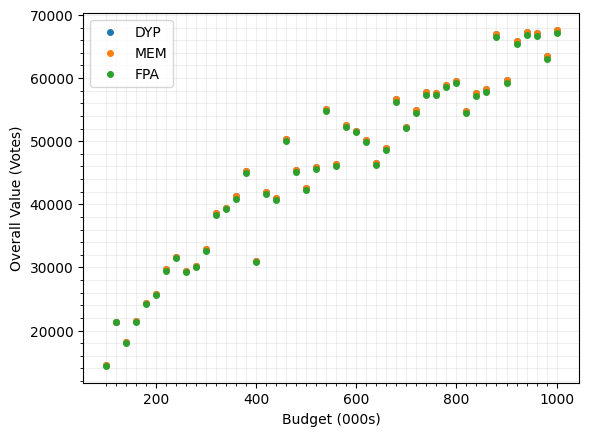

In [42]:
# COMPARE DYNAMIC PROGRAMMING, MEMOIZATION AND FPTAS VALUE
rt_dyn_y = [
    get_y(exact_results, len(problems), PBSingleAlgorithm.DYNAMIC_PROGRAMMING, 0),
    get_y(exact_results, len(problems), PBSingleAlgorithm.MEMOIZATION, 0),
    get_y(approximation_results, len(problems), PBSingleAlgorithm.FPTAS, 0)
]
dyn_labels = ['DYP', 'MEM', 'FPA']

plot_all_y(
    x_axis=list(range(min_budget, max_budget + 1, step_budget)),
    y_axes=rt_dyn_y,
    labels=dyn_labels,
    marker='o',
    marker_sizes=marker_size_cycle,
    x_label='Budget (000s)',
    y_label='Overall Value (Votes)',
)